# Download relevant libraries

In [ ]:
!pip3 -q install yfinance torch tensorboard_logger

In [ ]:
!pip3 install pandas --upgrade

In [ ]:
!git clone https://github.com/ojus1/Date2Vec
!git clone https://github.com/mattalejo/transformers

fatal: destination path 'Date2Vec' already exists and is not an empty directory.
fatal: destination path 'transformers' already exists and is not an empty directory.


In [ ]:
%cd transformers
!pip3 install -e .
%cd ..

/content/transformers
Obtaining file:///content/transformers
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for transformers (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.35.0.dev0-0.editable-py3-none-any.whl size=39569 sha256=b8dafd6efb9138f623b8e646f8bdf85087dab8b1364fcd1517c52e097d81f1e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-fxdmj615/wheels/7c/35/80/e946b22a081210c6642e607ed65b2a5b9a4d9259695ee2caf5
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.0.dev0
    Uninstalling transformers-4.35.0.dev0:
      Successfully uninstalled transformers-4.35.0.dev0
/content


# Import necessary libraries

In [ ]:
import yfinance as yf
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import math as m

from sklearn.preprocessing import StandardScaler
from tensorboard_logger import configure

import copy
import sys
import os

sys.path.append('/content/Date2Vec')
sys.path.append('/content/transformers')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader, TensorDataset

from Experiment import Date2VecExperiment
from Model import Date2Vec, Date2VecConvert

from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel, TimeSeriesTransformerForPrediction

In [ ]:
if torch.cuda.is_available():
 dev = "cuda:0"
else:
 dev = "cpu"
device = torch.device(dev)

print(dev)

cuda:0


# Load data

In [ ]:
asean_exchanges = ["PSEI.PS"]

In [ ]:
raw_data = yf.download(asean_exchanges, '2000-1-1','2022-12-31')
raw_data.fillna(method='ffill', inplace=True)
raw_data.tail()

[*********************100%%**********************]  1 of 1 completed


<ipython-input-9-1386ae6f31c9>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  raw_data.fillna(method='ffill', inplace=True)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-22,6540.930176,6580.209961,6521.669922,6576.939941,6576.939941,183700
2022-12-23,6567.919922,6567.919922,6536.669922,6541.029785,6541.029785,56100
2022-12-27,6549.089844,6579.259766,6519.899902,6564.899902,6564.899902,75400
2022-12-28,6567.129883,6576.709961,6530.270020,6566.540039,6566.540039,88600
2022-12-29,6553.669922,6591.279785,6529.689941,6566.390137,6566.390137,161100


In [ ]:
log_returns_raw = np.log(raw_data['Adj Close']/raw_data['Adj Close'].shift(1)).dropna()
returns_raw = raw_data['Adj Close'].pct_change().dropna()
raw_data["Log Returns"] = log_returns_raw
raw_data["Returns"] = returns_raw
raw_data.iloc[1::]

,Open,High,Low,Close,Adj Close,Volume,Log Returns,Returns
Date,,,,,,,,
2000-01-04,2151.550049,2158.209961,2130.679932,2153.179932,2152.626465,0,0.005313,0.005327
2000-01-05,2113.379883,2113.379883,2070.139893,2074.750000,2074.216553,0,-0.037105,-0.036425
2000-01-06,2079.050049,2082.810059,2066.879883,2079.110107,2078.575684,0,0.002099,0.002102
2000-01-07,2079.320068,2094.290039,2077.649902,2094.290039,2093.751709,0,0.007275,0.007301
2000-01-10,2105.610107,2147.889893,2105.610107,2142.250000,2141.699219,0,0.022642,0.022900
...,...,...,...,...,...,...,...,...
2022-12-22,6540.930176,6580.209961,6521.669922,6576.939941,6576.939941,183700,0.008573,0.008609
2022-12-23,6567.919922,6567.919922,6536.669922,6541.029785,6541.029785,56100,-0.005475,-0.005460
2022-12-27,6549.089844,6579.259766,6519.899902,6564.899902,6564.899902,75400,0.003643,0.003649


# Data preprocessing

In [ ]:
batch = int(32)
sequence_length = int(128)
prediction_length = int(6)

# Time2Vec Positional Encoding

In [ ]:
#   act = 'cos'
# optim = 'adam'
# os.system("mkdir /content/Date2Vec/models/d2v_{}".format(act))
# configure("/content/Date2Vec/logs/d2v_{}".format(act))

# # k is the embedding dimension
# # act is the periodic activation function for hidden layer
# m = Date2Vec(k = batch, act = act)
# exp = Date2VecExperiment(m, act, cuda=True, lr=0.001, optim=optim)
# exp.train()
# exp.test()

FileNotFoundError: ignored

In [ ]:
d2v = Date2VecConvert(model_path="/content/Date2Vec/d2v_model/d2v_98291_17.169918439404636.pth")

/usr/local/lib/python3.10/dist-packages/torch/serialization.py:888: SourceChangeWarning: source code of class 'Model.Date2Vec' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.10/dist-packages/torch/serialization.py:888: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.10/dist-packages/torch/serialization.py:888: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.d

In [ ]:
log_returns = pd.DataFrame(log_returns_raw)
log_returns.columns = ['y1']

for i in range(prediction_length-1):
  log_returns[f"y{i+2}"] = log_returns["y1"].shift((i+1))


for i in range(sequence_length):
  log_returns[f"x{i+1}"] = log_returns["y1"].shift(-(i+1))

log_returns = log_returns.dropna()

<ipython-input-14-15cbc42275b8>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  log_returns[f"x{i+1}"] = log_returns["y1"].shift(-(i+1))
<ipython-input-14-15cbc42275b8>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  log_returns[f"x{i+1}"] = log_returns["y1"].shift(-(i+1))
<ipython-input-14-15cbc42275b8>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get

In [ ]:
scaler = StandardScaler().fit(log_returns)
scaler_raw = StandardScaler().fit(log_returns_raw.to_numpy().reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [ ]:
input_columns = [f"x{i+1}" for i in range(sequence_length)]
output_columns = [f"y{i+1}" for i in range(prediction_length)]
columns = output_columns + input_columns

In [ ]:
log_returns = pd.DataFrame(scaler.transform(log_returns), columns = columns, index = log_returns.index)
log_returns

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


,y1,y2,y3,y4,y5,y6,x1,x2,x3,x4,...,x119,x120,x121,x122,x123,x124,x125,x126,x127,x128
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-11,-0.066728,1.715531,0.540863,0.145166,-2.848902,0.390857,-1.447019,-0.618177,0.627203,-0.192289,...,-0.555447,-0.163748,0.062507,0.066837,0.042616,0.062950,0.141253,0.031870,0.103995,0.386353
2000-01-12,-1.447129,-0.067261,1.715453,0.540745,0.145574,-2.849213,-0.617761,0.627614,-0.192494,-0.835214,...,-0.163806,0.062363,0.066917,0.042735,0.063059,0.141165,0.031892,0.103989,0.386331,0.324143
2000-01-13,-0.617607,-1.447506,-0.067629,1.715372,0.540864,0.145374,0.627803,-0.192175,-0.835412,-0.990191,...,0.062313,0.066774,0.042815,0.063179,0.141277,0.031802,0.104011,0.386325,0.324120,0.250982
2000-01-14,0.628352,-0.618078,-1.448100,-0.067766,1.714636,0.540679,-0.191836,-0.835166,-0.990387,0.165276,...,0.066724,0.042670,0.063260,0.141401,0.031910,0.103923,0.386348,0.324114,0.250959,-0.438762
2000-01-17,-0.191548,0.627740,-0.618537,-1.448280,-0.067203,1.714495,-0.834710,-0.990158,0.165068,0.329868,...,0.042619,0.063116,0.141483,0.032029,0.104033,0.386264,0.324137,0.250953,-0.438785,0.322294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-17,-0.752471,0.869983,-1.868584,0.073528,-0.755614,-2.642672,0.014100,-0.605371,-1.453429,-1.298942,...,0.623704,0.039337,-0.052600,0.360293,-0.581827,-0.845778,-0.997218,0.502728,0.721052,0.637741
2022-06-20,0.014454,-0.752926,0.869767,-1.868777,0.073988,-0.755847,-0.604957,-1.453252,-1.299135,1.880359,...,0.039286,-0.052754,0.360380,-0.581736,-0.845702,-0.997326,0.502751,0.721046,0.637718,-0.439968
2022-06-21,-0.604799,0.013912,-0.753407,0.869659,-1.866903,0.073785,-1.452683,-1.298941,1.880132,0.245779,...,-0.052808,0.360262,-0.581670,-0.845624,-0.997255,0.502669,0.721070,0.637712,-0.439990,0.259525


In [ ]:
input = log_returns[input_columns[::-1]]
output = log_returns[output_columns]

In [ ]:
input_tensor = torch.tensor(input.values, dtype=float)
print(input_tensor)

output_tensor = torch.tensor(output.values, dtype=float)
print(output_tensor)

tensor([[ 3.8635e-01,  1.0400e-01,  3.1870e-02,  ...,  6.2720e-01,
         -6.1818e-01, -1.4470e+00],
        [ 3.2414e-01,  3.8633e-01,  1.0399e-01,  ..., -1.9249e-01,
          6.2761e-01, -6.1776e-01],
        [ 2.5098e-01,  3.2412e-01,  3.8632e-01,  ..., -8.3541e-01,
         -1.9218e-01,  6.2780e-01],
        ...,
        [ 2.5953e-01, -4.3999e-01,  6.3771e-01,  ...,  1.8801e+00,
         -1.2989e+00, -1.4527e+00],
        [-7.7013e-04,  2.5950e-01, -4.4000e-01,  ...,  2.4557e-01,
          1.8807e+00, -1.2984e+00],
        [-2.1686e-02, -7.9267e-04,  2.5950e-01,  ...,  1.2792e+00,
          2.4594e-01,  1.8806e+00]], dtype=torch.float64)
tensor([[-0.0667,  1.7155,  0.5409,  0.1452, -2.8489,  0.3909],
        [-1.4471, -0.0673,  1.7155,  0.5407,  0.1456, -2.8492],
        [-0.6176, -1.4475, -0.0676,  1.7154,  0.5409,  0.1454],
        ...,
        [-0.6048,  0.0139, -0.7534,  0.8697, -1.8669,  0.0738],
        [-1.4528, -0.6053,  0.0136, -0.7536,  0.8695, -1.8672],
        [-1.29

In [ ]:
date = pd.DataFrame(index = raw_data.index)
y = pd.DatetimeIndex(raw_data.index).year.astype(np.float32)
m = pd.DatetimeIndex(raw_data.index).month.astype(np.float32)
d = pd.DatetimeIndex(raw_data.index).day.astype(np.float32)
date['h'] = 17
date['min'] = 0
date['s'] = 0
date['y'] = y
date['m'] = m
date['d'] = d
datetime = torch.tensor(date.values).float()
t2v = d2v(datetime)
t2v_aug=torch.reshape(torch.stack((t2v[:int(t2v.shape[0]/2)], t2v[int(t2v.shape[0]/2):]), -1), (int(t2v.shape[0]/2),int(t2v.shape[1]*2)))

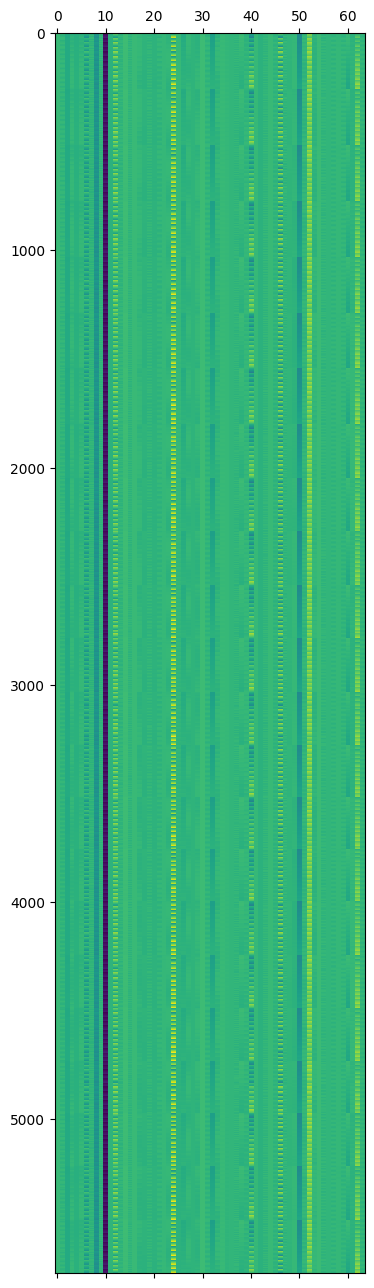

In [ ]:
plt.matshow(t2v_aug, aspect='auto')

In [ ]:
past_time_features_2 = torch.tensor([])
future_time_features_2 = torch.tensor([])

past_time_features_1 = torch.tensor([])
future_time_features_1 = torch.tensor([])

for i in range(int(len(log_returns.index)/2)):
  past_time_features_1 = torch.cat((past_time_features_1, torch.tensor(t2v_aug[i:i+sequence_length]).unsqueeze(0)))
  future_time_features_1 = torch.cat((future_time_features_1, torch.tensor(t2v_aug[i+sequence_length:i+sequence_length+prediction_length]).unsqueeze(0)))

for i in range(int(len(log_returns.index)/2),len(log_returns.index)):
  past_time_features_2 = torch.cat((past_time_features_2, torch.tensor(t2v_aug[i:i+sequence_length]).unsqueeze(0)))
  future_time_features_2 = torch.cat((future_time_features_2, torch.tensor(t2v_aug[i+sequence_length:i+sequence_length+prediction_length]).unsqueeze(0)))

<ipython-input-22-148565c8b046>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  past_time_features_1 = torch.cat((past_time_features_1, torch.tensor(t2v_aug[i:i+sequence_length]).unsqueeze(0)))
<ipython-input-22-148565c8b046>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  future_time_features_1 = torch.cat((future_time_features_1, torch.tensor(t2v_aug[i+sequence_length:i+sequence_length+prediction_length]).unsqueeze(0)))
<ipython-input-22-148565c8b046>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  past_time_features_2 = torch.cat((

In [ ]:
past_time_features = torch.cat((past_time_features_1, past_time_features_2))
future_time_features = torch.cat((future_time_features_1, future_time_features_2))

In [ ]:
past_time_features.shape

torch.Size([5576, 128, 64])

In [ ]:
dataset = TensorDataset(input_tensor, output_tensor)
dataset_time = TensorDataset(past_time_features, future_time_features)

dataloader = DataLoader(dataset, batch_size = batch)
dataloader_time = DataLoader(dataset_time, batch_size = batch)

In [ ]:
past_observed_mask = torch.ones((32,128,1))

In [ ]:
input_dim = 1  # Number of input features (e.g., univariate time series)
nhead = 4    # Number of attention heads
dmodel =  32  # Hidden dimension of the model
nlayers = 2    # Number of encoder and decoder layers
dropout = 0.1   # Dropout rate
learning_rate = 0.001
epochs = 32

In [ ]:
configuration = TimeSeriesTransformerConfig(
    input_size = 1,
    prediction_length = prediction_length,
    context_length = 64,
    num_time_features = 64,
    encoder_layers = nlayers,
    decoder_layers = nlayers,
    encoder_attention_heads = nhead,
    decoder_attention_heads = nhead,
    scaling='mean',
    num_dynamic_real_features=0,
    num_static_real_features = 0,
    num_dynamic_categorical_features = 0,
    num_static_categorical_features= 0)

In [ ]:
configuration.lags_sequence

[1, 2, 3, 4, 5, 6, 7]

In [ ]:
model = TimeSeriesTransformerForPrediction(configuration)
model.config

TimeSeriesTransformerConfig {
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "attention_dropout": 0.1,
  "cardinality": [
    0
  ],
  "context_length": 64,
  "d_model": 64,
  "decoder_attention_heads": 4,
  "decoder_ffn_dim": 32,
  "decoder_layerdrop": 0.1,
  "decoder_layers": 2,
  "distribution_output": "student_t",
  "dropout": 0.1,
  "embedding_dimension": [
    0
  ],
  "encoder_attention_heads": 4,
  "encoder_ffn_dim": 32,
  "encoder_layerdrop": 0.1,
  "encoder_layers": 2,
  "feature_size": 73,
  "init_std": 0.02,
  "input_size": 1,
  "is_encoder_decoder": true,
  "lags_sequence": [
    1,
    2,
    3,
    4,
    5,
    6,
    7
  ],
  "loss": "nll",
  "model_type": "time_series_transformer",
  "num_dynamic_categorical_features": 0,
  "num_dynamic_real_features": 0,
  "num_parallel_samples": 100,
  "num_static_categorical_features": 0,
  "num_static_real_features": 0,
  "num_time_features": 64,
  "prediction_length": 6,
  "scaling": "mean",
  "transformers_versi

In [ ]:
i = 0

model = model.to(device)

for data, time in zip(dataloader, dataloader_time):
  input_data, output_data = data
  input_time, output_time = time
  i += 1
  print(i, input_data.unsqueeze(2).shape,past_observed_mask.shape, output_data.unsqueeze(2).shape, input_time.squeeze().shape, output_time.squeeze().shape)


  outputs = model(
    past_values = input_data.unsqueeze(2),
    past_time_features = input_time,
    past_observed_mask = past_observed_mask,
    future_values = output_data.unsqueeze(2),
    future_time_features = output_time,
    static_categorical_features = None,
    static_real_features = None
    )
  print(outputs)

1 torch.Size([32, 128, 1]) torch.Size([32, 128, 1]) torch.Size([32, 6, 1]) torch.Size([32, 128, 64]) torch.Size([32, 6, 64])


RuntimeError: ignored

In [ ]:
torch.cat((input_data.unsqueeze(2), input_time), dim=2).shape

In [ ]:
plt.plot(log_returns_raw_tensor)

In [ ]:
outputs = model(
    past_values = input_tensor,
    past_time_features = past_time_features,
    past_observed_mask = past_observed_mask,
    future_values = output_tensor,
    future_time_features = future_time_features
)

In [ ]:
transformer_model = nn.Transformer(nhead=nhead,
                                   num_encoder_layers=nlayers,
                                   num_decoder_layers=nlayers,
                                   d_model=64,
                                   batch_first=True)
criterion = nn.MSELoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(epochs):
  total_loss = 0
  for data, time in zip(dataloader, dataloader_time):
    input_data, output_data = data
    input_time, output_time = time

    embed = nn.Linear(1, 64)
    input_data = embed(input_data.unsqueeze(2).float())
    output_data = embed(output_data.unsqueeze(2).float())

    input_data = input_data + input_time
    input_data = output_data + output_time

    # train = torch.add((input_data.unsqueeze(2), input_time))
    # test = torch.add((output_data.unsqueeze(2), output_time))

    # print(input_data.size(), output_data.size())

    transformer_model.train()
    optimizer.zero_grad()

    predictions = transformer_model(input_data, output_data)
    loss = criterion(predictions, output_data)

    input_data, _ = data
    predictions -= output_time
    output_data -= output_time


    plt.plot(predictions.squeeze(1), output_data.squeeze(1))

    loss.backward()
    optimizer.step()

    total_loss += loss

  print(f"Total train loss: {total_loss}")


    # model_t.train()
    # total_loss = 0
    # for i in range(0, len(y_train) - sequence_length):
    #     batch_x = torch.tensor(y_train_1.iloc[i:i+sequence_length], dtype=torch.long)
    #     batch_y = torch.tensor(y_train_1.iloc[i+sequence_length], dtype=torch.long)

    #     optimizer.zero_grad()

    #     predictions = model_t(batch_x)
    #     loss = criterion(predictions.squeeze(), batch_y)

    #     loss.backward()
    #     optimizer.step()

    #     total_loss += loss.item()

    # average_loss = total_loss / (len(y_train_1) - sequence_length)
    # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")




In [ ]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout):
        super(TimeSeriesTransformer, self).__init__()

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout),
            num_layers=num_encoder_layers
        )

        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout),
            num_layers=num_decoder_layers
        )

        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, src, tgt):
        # src: Input time series sequence (seq_len, batch_size, input_dim)
        # tgt: Target time series sequence (seq_len, batch_size, input_dim)

        encoder_out = self.encoder(src)
        decoder_out = self.decoder(tgt, encoder_out)
        output = self.fc(decoder_out)

        return output